In [ ]:
### VVV STEP 1 FROM INSTRUCTIONS VVV

import librosa
from utils import load_spectrograms, mp3_to_wav, split_large_wav
import os
import json

fpath = "static//data//Podcast-best-movies-of-2018"

def generate_empty_json():

    out = {}

    for i in os.listdir(os.path.join('static','data','samples')):
        out[i.split('.')[0]] = {'label': []}

    with open(os.path.join('static','data','labels.json'), 'w') as f:
        json.dump(out, f)


### optional: if your file is mp3, needs to be converted to wav
# mp3_to_wav(fpath)

### splitting large wav into 5 second clips, for better training and labeling
# split_large_wav(fpath, 5, fpath.split('//')[1])

### generate empty json for labels; CAREFUL, THIS WILL OVERWRITE YOUR LABELS!
# generate_empty_json()

In [26]:
### performance of different models

### 0 / -ve - model predicts to cut audio
### 1 / +ve - model predicts to leave audio in
### minimizing false negatives matters more than false positives for this model, so we focus on recall more than precision

import tensorflow as tf
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time

template = 'Podcast-best-movies-of-2018'

f = open(os.path.join('static','data','labels.json'),) 
data = json.load(f)

fnames, batch_labels = [], []

for i in range(501,531):
    fnames.append(f'{template}_{i}')
    batch_labels.append( np.asarray(data[f'{template}_{i}']['label']) )

batch_samples, batch_labels, orig_lens = load_batch(fnames, batch_labels)

model_perf = {}

labels_list = []
for i in batch_labels:
    labels_list += list(i)

for i, modelFname in enumerate(os.listdir('savedModels')):
    
    print(modelFname)
        
    model_perf[modelFname] = {}

    t1 = time.time()
    model = tf.keras.models.load_model(os.path.join('savedModels',modelFname))
    t2 = time.time()
    output = model.predict([batch_samples])
    t3 = time.time()
    
    output_list = []
    for i in output:
        output_list += list(i)

    thr = 0.15
    output_list = [1 if i >= thr else 0 for i in output_list]

    tn, fp, fn, tp = confusion_matrix(labels_list, output_list).ravel()
    
    model_perf[modelFname]['params'] = model.count_params()    
    model_perf[modelFname]['load_time'] = (t2 - t1)    
    model_perf[modelFname]['inference_time'] = (t3 - t2)
    model_perf[modelFname]['tn'] = tn
    model_perf[modelFname]['fp'] = fp
    model_perf[modelFname]['fn'] = fn
    model_perf[modelFname]['tp'] = tp
    model_perf[modelFname]['prec'] = tp / ( tp + fp )
    model_perf[modelFname]['rec'] = tp / ( tp + fn )
    model_perf[modelFname]['acc'] = ( tp + tn ) / ( tp + tn + fp + fn )

audioCleaning_levels-0_repeat-1_level1-20_1599607987.h5
audioCleaning_levels-0_repeat-1_level1-80_1599607504.h5
audioCleaning_levels-6_repeat-1_level1-80_1599606542.h5
audioCleaning_levels-6_repeat-2_level1-80_1599606149.h5


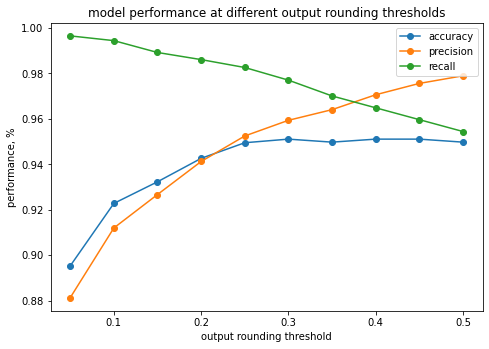

In [31]:
### output ranges from 0.0 to 1.0, as probability of leaving the audio timestep in
### after testing different thresholds of rounding, accuracy tops at around 0.25 but 0.15 sounds slightly better for conversational audio IMO
### I will be using threshold = 0.15 from this point forward

acc_thr, rec_thr, prec_thr, thrs = [], [], [], []

for j in range(5,51,5):

    output = model.predict([batch_samples])

    output_list = []
    for i in output:
        output_list += list(i)

    thr = j / 100
    output_list = [1 if j >= thr else 0 for j in output_list]

    tn, fp, fn, tp = confusion_matrix(labels_list, output_list).ravel()
    
    acc_thr.append( ( tp + tn ) / ( tp + tn + fp + fn ) )
    prec_thr.append( tp / ( tp + fp ) )
    rec_thr.append( tp / ( tp + fn ) )
    thrs.append( thr )

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(
    thrs,
    acc_thr,
    marker='o',
    label='accuracy'
)
ax.plot(
    thrs,
    prec_thr,
    marker='o',
    label='precision'
)
ax.plot(
    thrs,
    rec_thr,
    marker='o',
    label='recall'
)
ax.legend()

plt.ylabel('performance, %')
plt.xlabel('output rounding threshold')
plt.title('model performance at different output rounding thresholds')
plt.show()

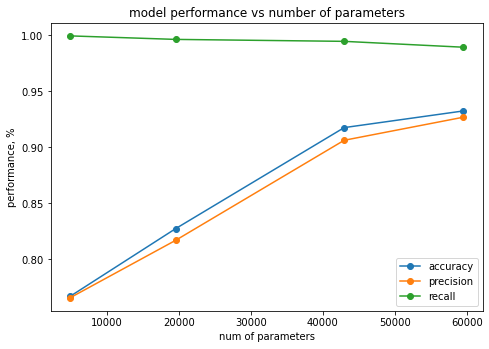

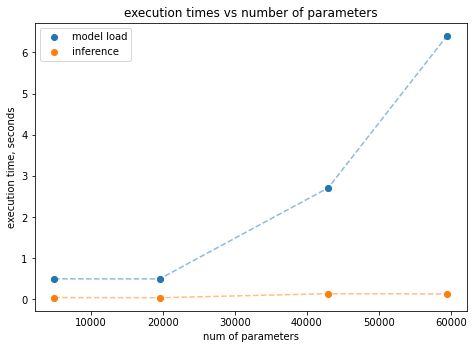

In [36]:
### model performance increases with more parameters
### slight tradeoff between precision and recall observed
### inference time increases with model size but most of it comes from model loading
### overall depending on the application, different model sizes can be chosen to prioritize speed vs performance

names, acc, rec, prec, load_time, infer_time, params = [], [], [], [], [], [], []

i = 0
for k, v in model_perf.items():
    names.append(k)
    acc.append(v['acc'])
    rec.append(v['rec'])
    prec.append(v['prec'])
    load_time.append(v['load_time'])
    infer_time.append(v['inference_time'])
    params.append(v['params'])
    
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(
    params,
    acc,
    marker='o',
    label='accuracy'
)
ax.plot(
    params,
    prec,
    marker='o',
    label='precision'
)
ax.plot(
    params,
    rec,
    marker='o',
    label='recall'
)
ax.legend()

plt.ylabel('performance, %')
plt.xlabel('num of parameters')
plt.title('model performance vs number of parameters')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(
    params,
    load_time,
    marker='o',
    linestyle='dashed',
    alpha=0.5
)
ax.scatter(
    params,
    load_time,
    label='model load'
)
ax.plot(
    params,
    infer_time,
    marker='o',
    linestyle='dashed',
    alpha=0.5
)
ax.scatter(
    params,
    infer_time,
    label='inference'
)
ax.legend()

plt.ylabel('execution time, seconds')
plt.xlabel('num of parameters')
plt.title('execution times vs number of parameters')
plt.show()

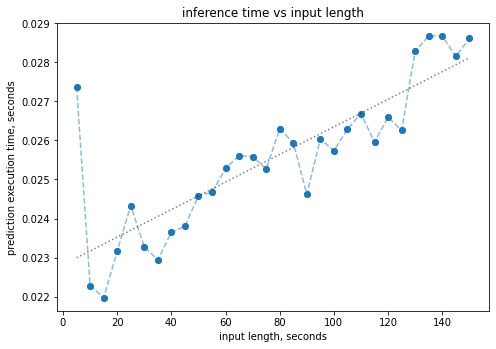

In [33]:
### inference time increases linearly with input size

# lens, times = [], []

# for i in range(1,batch_samples.shape[0]+1,1):
#     t1 = time.time()
#     for _ in range(3):
#         preds = model.predict(batch_samples[:i])
#     t2 = time.time()
    
#     lens.append(i*5)
#     times.append( (t2-t1) / 3 )    

lin = np.linspace(min(lens),max(lens),100)
poly, stats = np.polynomial.polynomial.polyfit(lens, times, 1, full=True)

fit = [poly[0]+poly[1]*i for i in lin]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(
    lens,
    times,
    marker='o',
    linestyle='dashed',
    alpha=0.5
)
ax.scatter(
    lens,
    times,
    label='inference'
)
ax.plot(
    lin,
    fit,
    linestyle='dotted',
    color='black',
    alpha=0.5
)

plt.ylabel('prediction execution time, seconds')
plt.xlabel('input length, seconds')
plt.title('inference time vs input length')
plt.show()

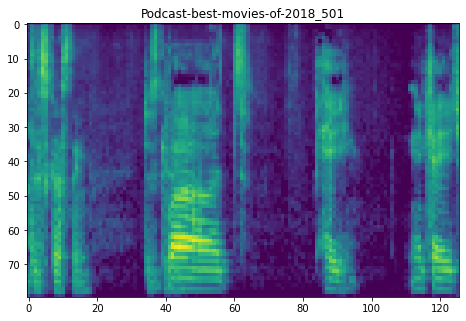

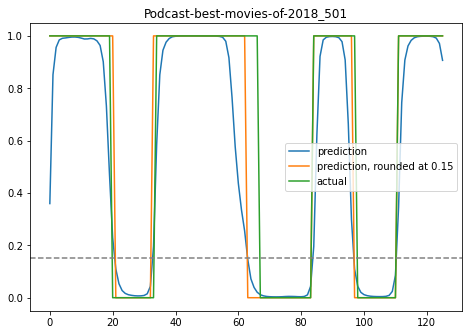

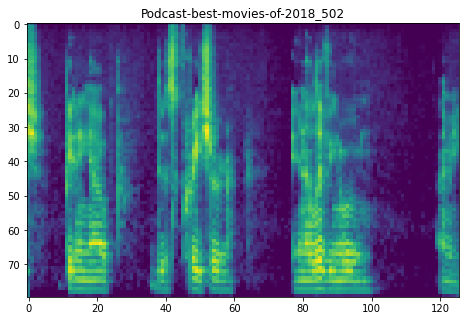

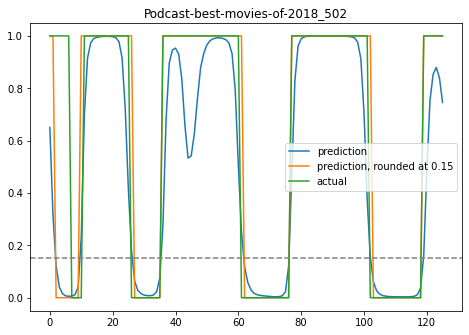

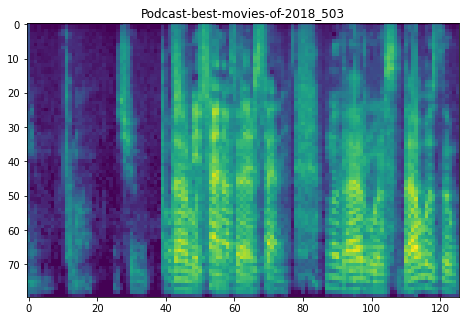

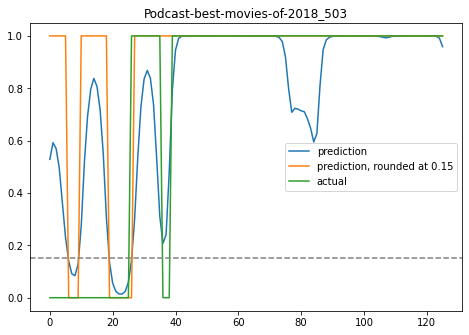

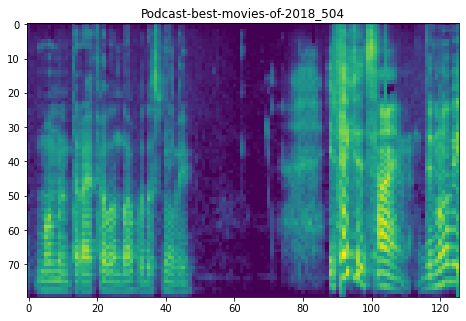

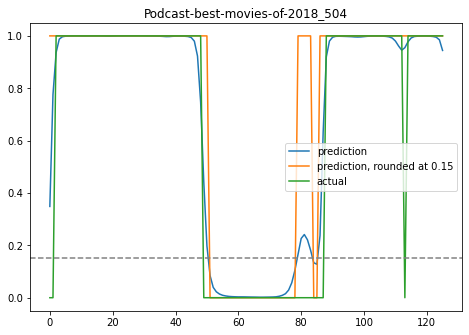

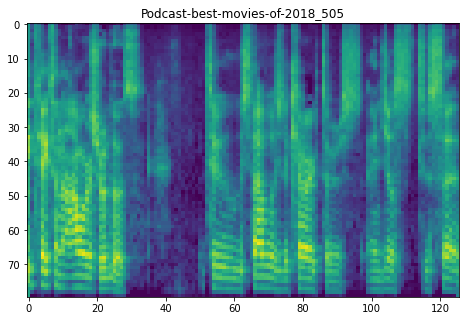

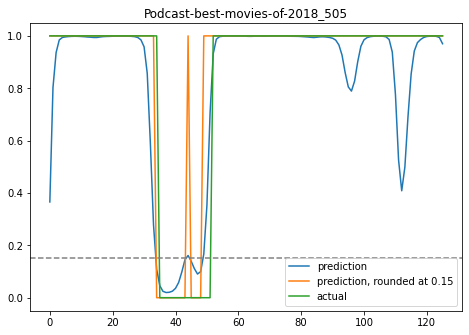

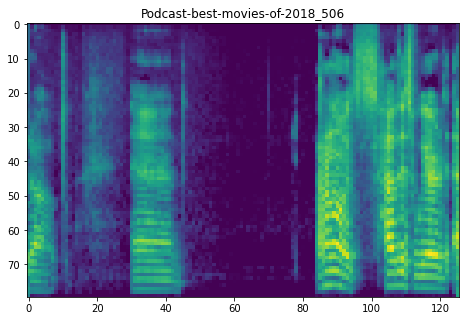

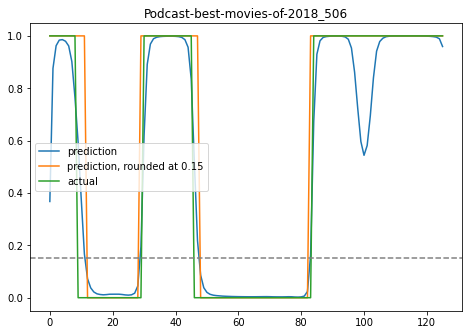

In [34]:
# visualize predictions

import tensorflow as tf
from utils import *
import numpy as np

template = 'Podcast-best-movies-of-2018'

f = open(os.path.join('static','data','labels.json'),) 
data = json.load(f)

fnames, batch_labels = [], []

for i in range(501,507):
    fnames.append(f'{template}_{i}')
    batch_labels.append( np.asarray(data[f'{template}_{i}']['label']) )

batch_samples, batch_labels, orig_lens = load_batch(fnames, batch_labels)

modelFname = os.listdir('savedModels')[-1]
model = tf.keras.models.load_model(os.path.join('savedModels',modelFname))
output = model.predict([batch_samples])

for name, out, lab, inpt in zip(fnames, output, batch_labels, batch_samples):
    out = np.transpose(out)[0]
    
    inpt = np.asarray([i[::-1] for i in inpt])
    inpt = np.transpose(inpt)
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    ax.imshow(
        inpt
    )

    plt.title(name)
    plt.show()

    thr = 0.15
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    ax.plot(
        out,
        label='prediction'
    )
    ax.plot(
        [1 if i >= thr else 0 for i in out],
        label=f'prediction, rounded at {thr}'
    )
    ax.plot(
        lab,
        label='actual'
    )
    ax.legend()
    
    ax.axhline(y=thr, color='grey', linestyle='dashed')

    plt.title(name)
    plt.show()
    

In [35]:
# generate edited audio clip based on predictions

from hyperparams import Hyperparams as hp
from scipy.io.wavfile import write

raw, correct, edited = [], [], []

for name, out, lab, orig in zip(fnames, output, batch_labels, orig_lens):
    out = np.transpose(out)[0]
    
    out = [1 if i >= 0.15 else 0 for i in out]
    
    out, lab = out[:orig], lab[:orig]
    
    y, sr = librosa.load(os.path.join('static','data','samples',f'{name}.wav'), sr=hp.sr)

    sr_per_interval = len(y) // len(lab)

    raw += list(y)

    for i, v in enumerate(lab):
        if v == 1:
            l, r = i*sr_per_interval, (i+1)*sr_per_interval
            correct += list(y[l:r])

    for i, v in enumerate(out):
        if v == 1:
            l, r = i*sr_per_interval, (i+1)*sr_per_interval
            edited += list(y[l:r])

raw = np.array(raw)
correct = np.array(correct)
edited = np.array(edited)

print(raw.shape)
print(correct.shape)
print(edited.shape)

write(os.path.join('static','data',f'raw_test.wav'), hp.sr, raw)
write(os.path.join('static','data',f'correct_test.wav'), hp.sr, correct)
write(os.path.join('static','data',f'edited_test.wav'), hp.sr, edited)

(661500,)
(453250,)
(483875,)
